In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-y5o8vjxs
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-y5o8vjxs
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=fe94759825f3398e85f0093490fe9dac7d8b4f47733d58f03296e7aa3cc26bf1
  Stored in directory: /tmp/pip-ephem-wheel-cache-inrwdp5f/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
 os.chdir("/content/drive/My Drive/Utils")

In [6]:
from torchvision import transforms
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
from models.resnet import ResNet18
# import model as md
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from tqdm import tqdm
from albumentation import Albumentation
from gradcam import GradCAM, visualize_cam
from lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


### Create model and display summary

In [7]:

model_obj = ResNet18(dropout=0.1)

device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Get data set object

In [0]:
data_set_obj = DataSetInfo("cifa", "./data")

### Get the train test transforms 

In [0]:
import albumentations as A
import albumentations.pytorch as AP

import albumentations as A

means = (0.5, 0.5, 0.5)
stdevs = (0.5, 0.5, 0.5)
customised_transforms =  [ 
                            A.HorizontalFlip(),
                            A.Normalize(mean=means, std=stdevs),
                            A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1),
                            AP.ToTensor() 
                         ]
train_transforms = Albumentation(transforms = customised_transforms)
test_transforms=Albumentation(transforms = [A.Normalize(mean=means, std=stdevs), AP.ToTensor() ])


### Get Train and Test data set

In [10]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [11]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=128)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Show some training images

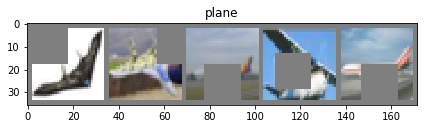

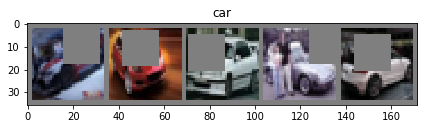

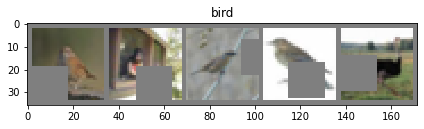

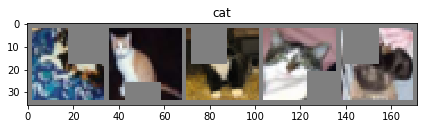

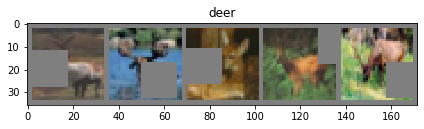

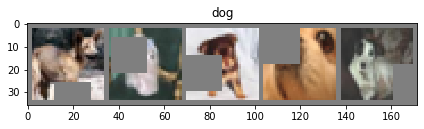

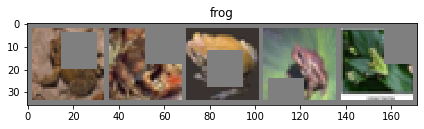

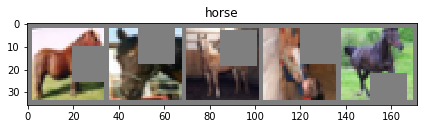

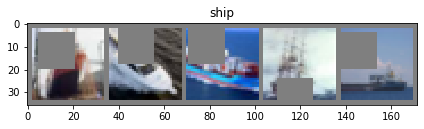

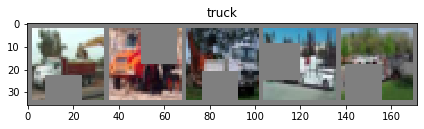

In [12]:
import torchvision
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
Plot.show_cifar_classwise_image(train_loader, classes)


### Find LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


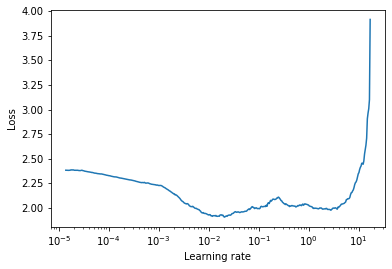

Best LR:  0.02044660666579116
Best loss 1.9080101168372685


In [13]:
# Use SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = helper_obj.get_l2_regularizer(weight_decay=0.0001, lr=1e-5, momentum=0.9) #SGD with l2 regulizer
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=500, step_mode="exp")
lr_finder.plot()
training_lr = lr_finder.get_best_lr()
lr_finder.reset()

### Run the model

In [14]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = helper_obj.get_l2_regularizer(weight_decay=0.0001, lr=training_lr, momentum=0.9) #SGD with l2
scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)
EPOCHS = 51


train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []

criterion = nn.CrossEntropyLoss()
requires_misclassified = False

for epoch in range(1, EPOCHS):

    print("EPOCH:", epoch)
    
    train_obj.train(model, device, train_loader, optimizer, criterion)
    if epoch == (EPOCHS - 1):
      requires_misclassified = True
    test_obj.test(model, device, test_loader, criterion, misclassfied_required=requires_misclassified)

    scheduler.step(metrics=test_obj.test_losses[-1])

    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])

misclassified_images = test_obj.misclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
correct_classified_images = test_obj.trueclassified_images
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Train Set: Train Loss=1.240338683128357 Batch_id=390 Accuracy=39.57: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0123, Accuracy: 4750/10000 (47.50%)

EPOCH: 2


Train Set: Train Loss=0.9798962473869324 Batch_id=390 Accuracy=56.13: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 6363/10000 (63.63%)

EPOCH: 3


Train Set: Train Loss=0.9677855372428894 Batch_id=390 Accuracy=63.29: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0069, Accuracy: 6920/10000 (69.20%)

EPOCH: 4


Train Set: Train Loss=0.7623822689056396 Batch_id=390 Accuracy=68.06: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6777/10000 (67.77%)

EPOCH: 5


Train Set: Train Loss=0.9639478921890259 Batch_id=390 Accuracy=70.98: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7465/10000 (74.65%)

EPOCH: 6


Train Set: Train Loss=0.7290744185447693 Batch_id=390 Accuracy=73.33: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7671/10000 (76.71%)

EPOCH: 7


Train Set: Train Loss=0.746478259563446 Batch_id=390 Accuracy=75.14: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7771/10000 (77.71%)

EPOCH: 8


Train Set: Train Loss=0.5385943651199341 Batch_id=390 Accuracy=76.80: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8129/10000 (81.29%)

EPOCH: 9


Train Set: Train Loss=0.7317949533462524 Batch_id=390 Accuracy=77.84: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7680/10000 (76.80%)

EPOCH: 10


Train Set: Train Loss=0.6999456286430359 Batch_id=390 Accuracy=79.18: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8172/10000 (81.72%)

EPOCH: 11


Train Set: Train Loss=0.44890278577804565 Batch_id=390 Accuracy=79.89: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8149/10000 (81.49%)

EPOCH: 12


Train Set: Train Loss=0.5333876013755798 Batch_id=390 Accuracy=80.92: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8069/10000 (80.69%)

EPOCH: 13


Train Set: Train Loss=0.7761541604995728 Batch_id=390 Accuracy=81.37: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8269/10000 (82.69%)

EPOCH: 14


Train Set: Train Loss=0.31897878646850586 Batch_id=390 Accuracy=82.31: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8552/10000 (85.52%)

EPOCH: 15


Train Set: Train Loss=0.6431642770767212 Batch_id=390 Accuracy=82.68: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8615/10000 (86.15%)

EPOCH: 16


Train Set: Train Loss=0.5163754820823669 Batch_id=390 Accuracy=83.47: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8523/10000 (85.23%)

EPOCH: 17


Train Set: Train Loss=0.35988089442253113 Batch_id=390 Accuracy=83.91: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8349/10000 (83.49%)

EPOCH: 18


Train Set: Train Loss=0.5799004435539246 Batch_id=390 Accuracy=84.27: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8636/10000 (86.36%)

EPOCH: 19


Train Set: Train Loss=0.3016895651817322 Batch_id=390 Accuracy=84.76: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8586/10000 (85.86%)

EPOCH: 20


Train Set: Train Loss=0.46858492493629456 Batch_id=390 Accuracy=85.25: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8710/10000 (87.10%)

EPOCH: 21


Train Set: Train Loss=0.46044713258743286 Batch_id=390 Accuracy=85.51: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8744/10000 (87.44%)

EPOCH: 22


Train Set: Train Loss=0.3257896900177002 Batch_id=390 Accuracy=85.96: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8729/10000 (87.29%)

EPOCH: 23


Train Set: Train Loss=0.5224666595458984 Batch_id=390 Accuracy=86.23: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8763/10000 (87.63%)

EPOCH: 24


Train Set: Train Loss=0.24717561900615692 Batch_id=390 Accuracy=86.60: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8688/10000 (86.88%)

EPOCH: 25


Train Set: Train Loss=0.40525713562965393 Batch_id=390 Accuracy=86.82: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8758/10000 (87.58%)

EPOCH: 26


Train Set: Train Loss=0.48862600326538086 Batch_id=390 Accuracy=87.09: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8790/10000 (87.90%)

EPOCH: 27


Train Set: Train Loss=0.4209986627101898 Batch_id=390 Accuracy=87.43: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8846/10000 (88.46%)

EPOCH: 28


Train Set: Train Loss=0.36692020297050476 Batch_id=390 Accuracy=87.61: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8803/10000 (88.03%)

EPOCH: 29


Train Set: Train Loss=0.3476610779762268 Batch_id=390 Accuracy=88.03: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8914/10000 (89.14%)

EPOCH: 30


Train Set: Train Loss=0.4582666754722595 Batch_id=390 Accuracy=88.27: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8882/10000 (88.82%)

EPOCH: 31


Train Set: Train Loss=0.2905659079551697 Batch_id=390 Accuracy=88.45: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8809/10000 (88.09%)

EPOCH: 32


Train Set: Train Loss=0.39196521043777466 Batch_id=390 Accuracy=88.57: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8768/10000 (87.68%)

EPOCH: 33


Train Set: Train Loss=0.14158064126968384 Batch_id=390 Accuracy=89.04: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8797/10000 (87.97%)

EPOCH: 34


Train Set: Train Loss=0.37175804376602173 Batch_id=390 Accuracy=89.02: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8819/10000 (88.19%)

EPOCH: 35


Train Set: Train Loss=0.2894301116466522 Batch_id=390 Accuracy=89.18: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8946/10000 (89.46%)

EPOCH: 36


Train Set: Train Loss=0.3882351517677307 Batch_id=390 Accuracy=89.59: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8943/10000 (89.43%)

EPOCH: 37


Train Set: Train Loss=0.4297091066837311 Batch_id=390 Accuracy=89.82: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8950/10000 (89.50%)

EPOCH: 38


Train Set: Train Loss=0.2865307927131653 Batch_id=390 Accuracy=89.97: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8950/10000 (89.50%)

EPOCH: 39


Train Set: Train Loss=0.3172566890716553 Batch_id=390 Accuracy=89.98: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8927/10000 (89.27%)

EPOCH: 40


Train Set: Train Loss=0.1811613291501999 Batch_id=390 Accuracy=90.22: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8927/10000 (89.27%)

EPOCH: 41


Train Set: Train Loss=0.28484266996383667 Batch_id=390 Accuracy=90.40: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8999/10000 (89.99%)

EPOCH: 42


Train Set: Train Loss=0.36274293065071106 Batch_id=390 Accuracy=90.66: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8922/10000 (89.22%)

EPOCH: 43


Train Set: Train Loss=0.2182018756866455 Batch_id=390 Accuracy=90.71: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8929/10000 (89.29%)

EPOCH: 44


Train Set: Train Loss=0.3158668279647827 Batch_id=390 Accuracy=90.75: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9026/10000 (90.26%)

EPOCH: 45


Train Set: Train Loss=0.36621105670928955 Batch_id=390 Accuracy=91.07: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8898/10000 (88.98%)

EPOCH: 46


Train Set: Train Loss=0.20596766471862793 Batch_id=390 Accuracy=91.10: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 8992/10000 (89.92%)

EPOCH: 47


Train Set: Train Loss=0.28390637040138245 Batch_id=390 Accuracy=91.12: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9033/10000 (90.33%)

EPOCH: 48


Train Set: Train Loss=0.34746646881103516 Batch_id=390 Accuracy=91.33: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8994/10000 (89.94%)

EPOCH: 49


Train Set: Train Loss=0.1468072235584259 Batch_id=390 Accuracy=91.76: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 8942/10000 (89.42%)

EPOCH: 50


Train Set: Train Loss=0.3455486297607422 Batch_id=390 Accuracy=91.58: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.0028, Accuracy: 8911/10000 (89.11%)

Maximum Training Accuracy =  91.76
Maximum Testing Accuracy =  90.33


### Display graphs

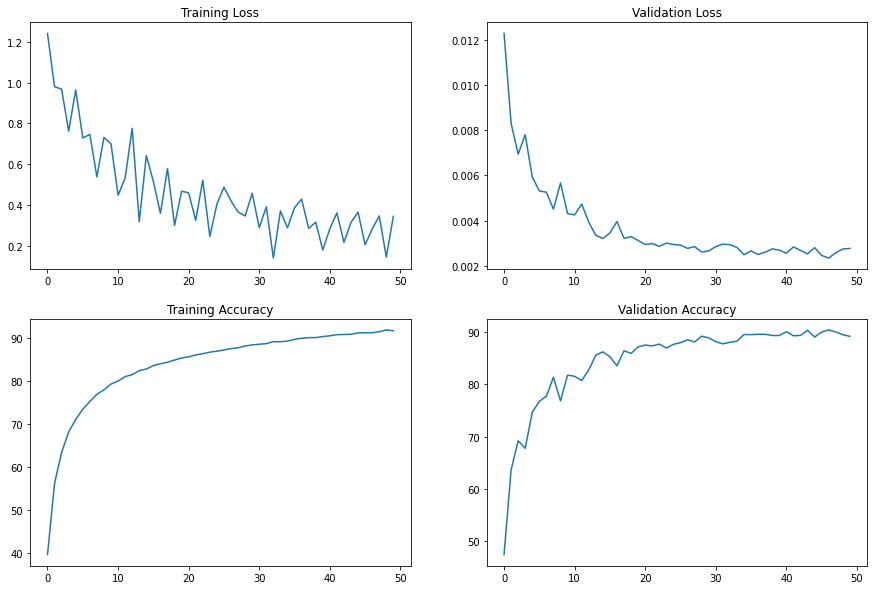

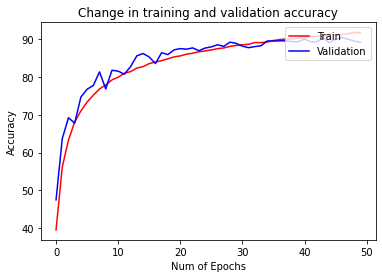

In [15]:
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
plt_obj.display_all_plot()
plt_obj.plot_graph()


###Display 25 misclassified images

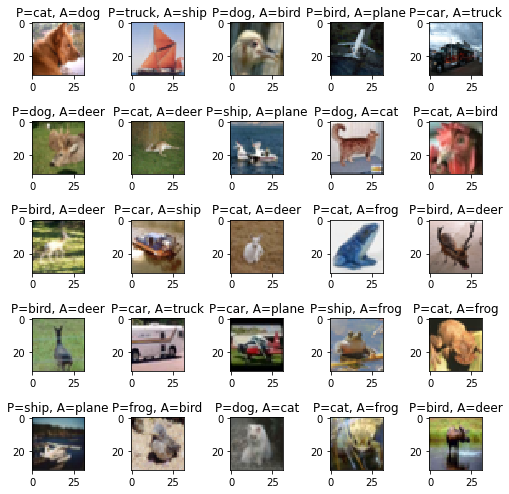

In [16]:
plt_obj.plot_cifar_misclassified(misclassified_images)

###Visualizing Gradcam results for 25 misclassified images in all layers

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


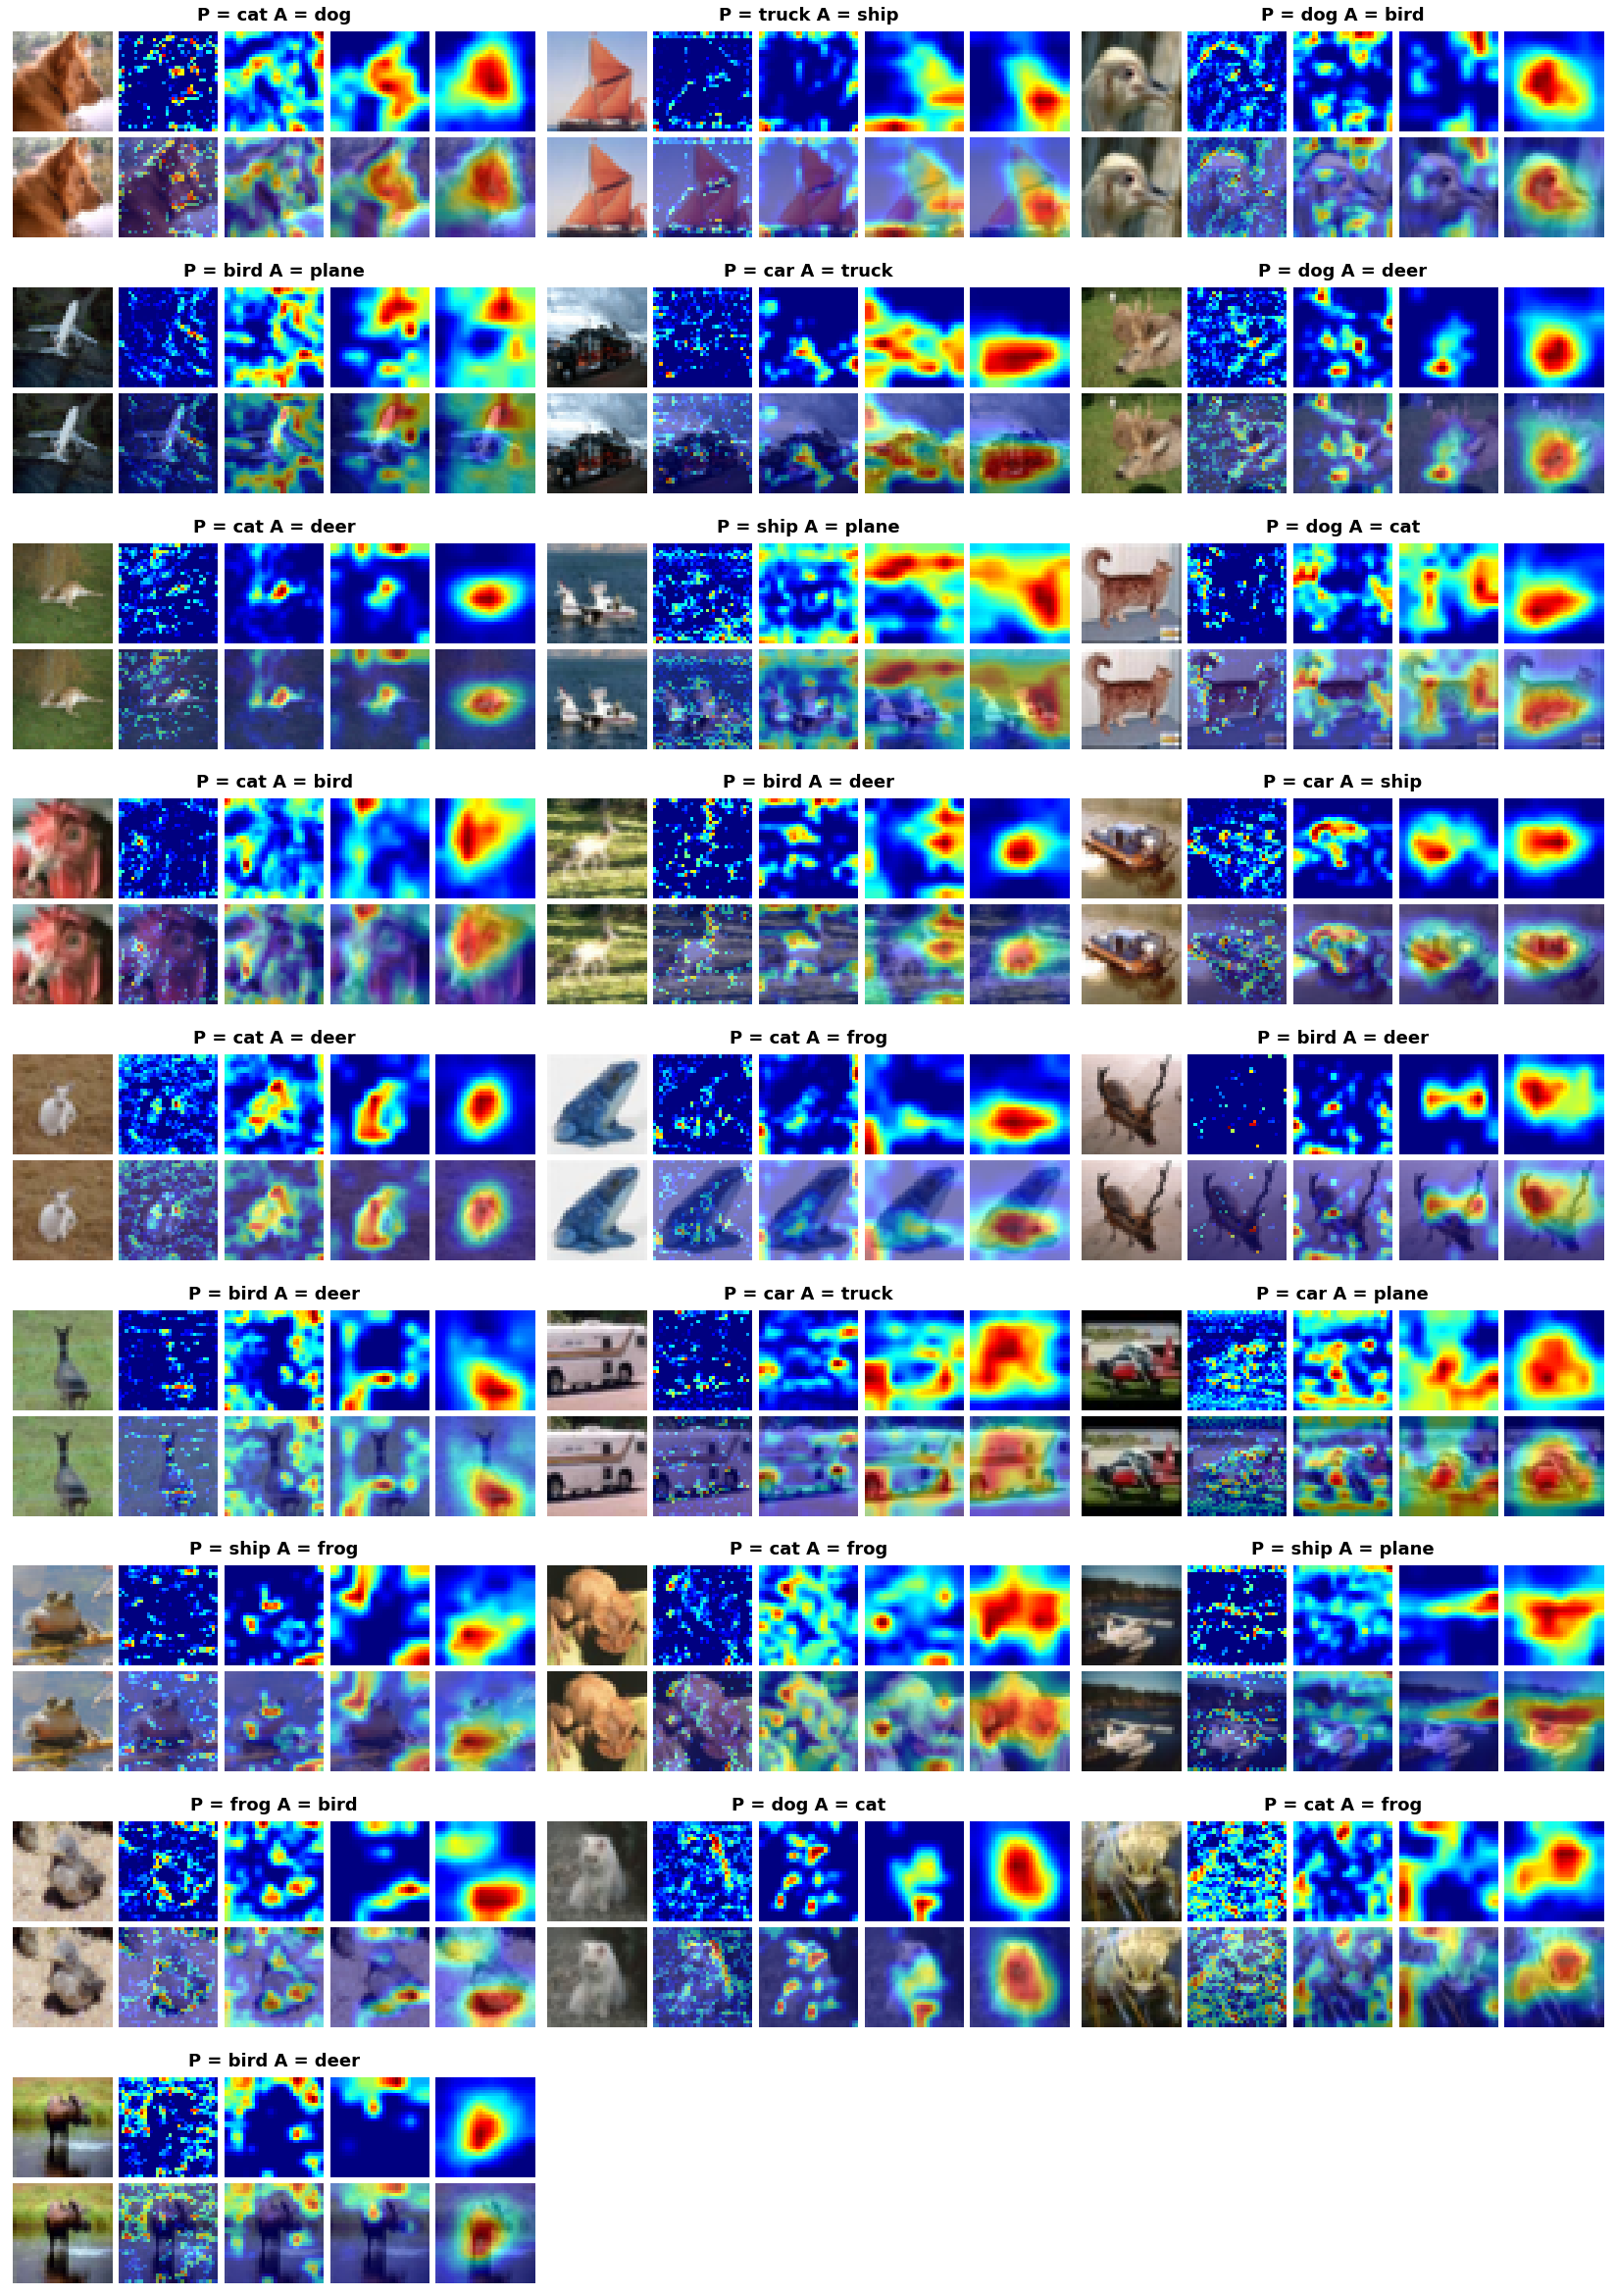

In [17]:
layers = [model.layer1, model.layer2, model.layer3, model.layer4]
helper_obj.get_gradcam_images(model,layers,misclassified_images,classes)